### Exemplo de Validação Cruzada

In [11]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml(name="house_prices", as_frame=True, return_X_y=True) 

In [12]:
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,RL,62.0,7917.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,8.0,2007.0,WD,Normal
1456,1457.0,20.0,RL,85.0,13175.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,MnPrv,None,0.0,2.0,2010.0,WD,Normal
1457,1458.0,70.0,RL,66.0,9042.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,GdPrv,Shed,2500.0,5.0,2010.0,WD,Normal
1458,1459.0,20.0,RL,68.0,9717.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,4.0,2010.0,WD,Normal


<AxesSubplot:xlabel='MSZoning'>

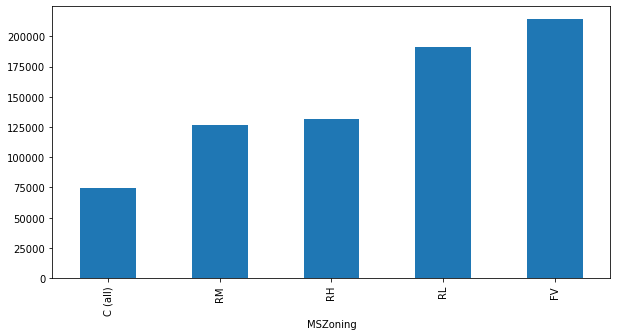

In [13]:
X.assign(y = y).groupby('MSZoning').y.mean().sort_values().plot(kind='bar', figsize=(10, 5))

In [14]:
Xtr = X.loc[:, ['LotArea', 'PoolArea','OverallQual', 'FullBath', 'MSZoning']]

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ScaleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='center'):
        if method not in ('center', 'standardize'):
            raise ValueError("method not in ('center', 'standardize')")
        self.method = method
    
    def fit(self, X, *args, **kwargs):
        self.means_ = X.mean(axis=0)
        
        if self.method == 'standardize':
            self.stds_ = X.std(axis=0)
        
        return self
    
    def transform(self, X):
        if self.method == 'standardize':
            return_frame = (X - self.means_) / self.stds_
        elif self.method=='center':
                return_frame = (X - self.means_)
        
        return return_frame
        

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline(steps=[
    ('centralizador', ScaleTransformer(method='standardize')),
    ('interacoes', PolynomialFeatures(interaction_only=True, include_bias=False))
])

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

pipeline1 = ColumnTransformer([
    ('interacoes', pipe, ['LotArea', 'OverallQual']),
    ('dummy_zoning', OneHotEncoder(drop='first'), ['MSZoning']),
    ('pool', 'passthrough', ['PoolArea'])
],
    remainder='drop'
)

In [18]:
from sklearn import set_config
set_config(display='diagram')

In [19]:
pipeline1

ColumnTransformer(transformers=[('interacoes',
                                 Pipeline(steps=[('centralizador',
                                                  ScaleTransformer(method='standardize')),
                                                 ('interacoes',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True))]),
                                 ['LotArea', 'OverallQual']),
                                ('dummy_zoning', OneHotEncoder(drop='first'),
                                 ['MSZoning']),
                                ('pool', 'passthrough', ['PoolArea'])])

In [20]:
from sklearn.linear_model import LinearRegression

modelo_1 = Pipeline([('transformacoes', pipeline1), ('modelo_liner', LinearRegression())])

In [24]:
from sklearn.model_selection import cross_val_score


-cross_val_score(modelo_1, Xtr, y, cv=10, scoring='neg_mean_squared_error').mean()

2133195722.0065703

In [25]:
pipeline2 = ColumnTransformer([
    ('interacoes', 'passthrough', ['LotArea', 'OverallQual']),
    ('dummy_zoning', OneHotEncoder(drop='first'), ['MSZoning']),
    ('pool', 'passthrough', ['PoolArea'])
],
    remainder='drop'
)


modelo_2 = Pipeline([('transformacoes', pipeline2), ('modelo_liner', LinearRegression())])

In [26]:
-cross_val_score(modelo_2, Xtr, y, cv=10, scoring='neg_mean_squared_error').mean()

2118865480.3149529

## Pré requisitos para inferência com modelos lineares

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 8]

# LOADING DATASET
fev = pd.read_csv('fev.csv')
fev.head(10)

,Id,Age,FEV,Hgt,Sex,Smoke
0,301,9,1.708,57.0,0,0
1,451,8,1.724,67.5,0,0
2,501,7,1.720,54.5,0,0
3,642,9,1.558,53.0,1,0
4,901,9,1.895,57.0,1,0
5,1701,8,2.336,61.0,0,0
6,1752,6,1.919,58.0,0,0
7,1753,6,1.415,56.0,0,0
8,1901,8,1.987,58.5,0,0
9,1951,9,1.942,60.0,0,0


In [2]:
fev[["Age", "FEV", "Hgt", "Sex"]].describe().round(1)

,Age,FEV,Hgt,Sex
count,654.0,654.0,654.0,654.0
mean,9.9,2.6,61.1,0.5
std,3.0,0.9,5.7,0.5
min,3.0,0.8,46.0,0.0
25%,8.0,2.0,57.0,0.0
50%,10.0,2.5,61.5,1.0
75%,12.0,3.1,65.5,1.0
max,19.0,5.8,74.0,1.0


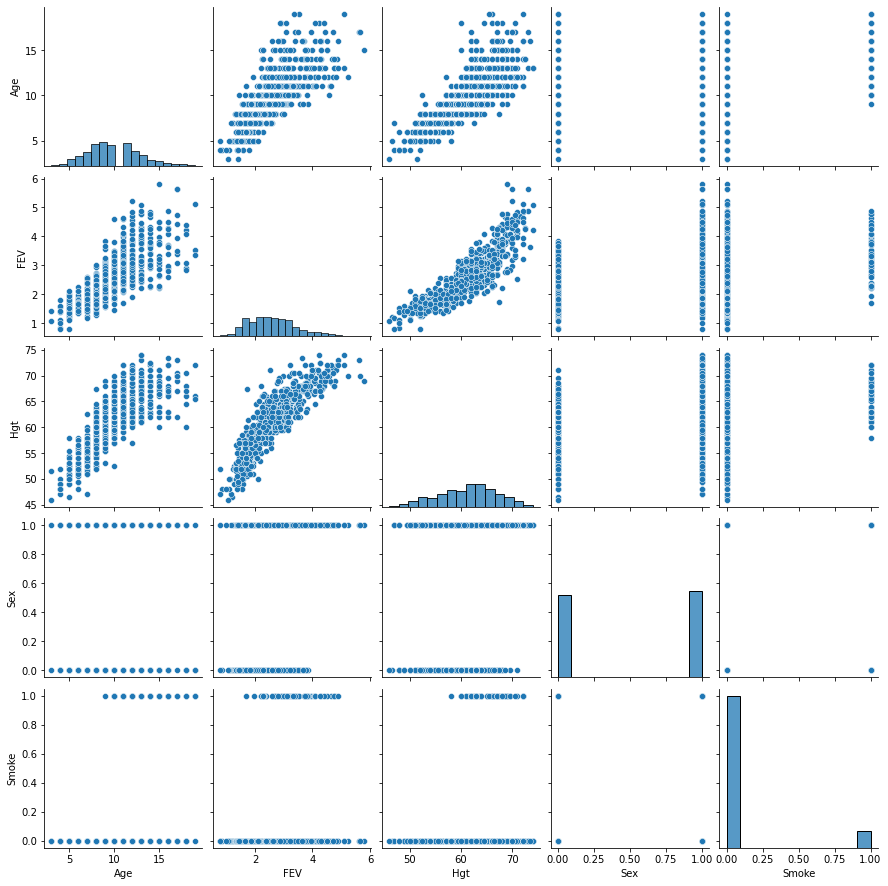

In [3]:
sns.pairplot(fev.drop(columns = ['Id']))
plt.show()

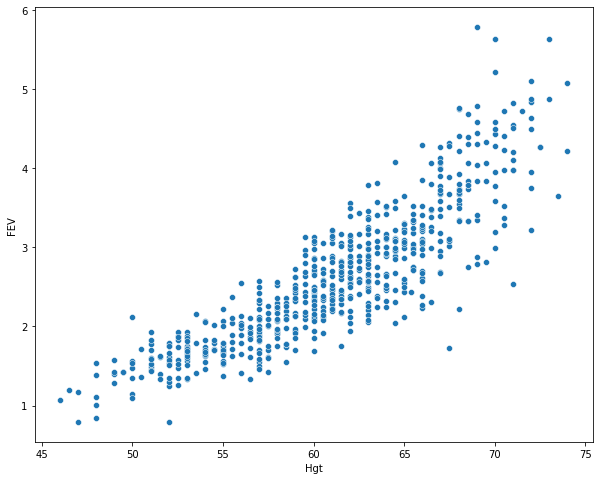

In [4]:
# SCATTER PLOT

sns.scatterplot(data=fev, x="Hgt", y="FEV")
plt.show()

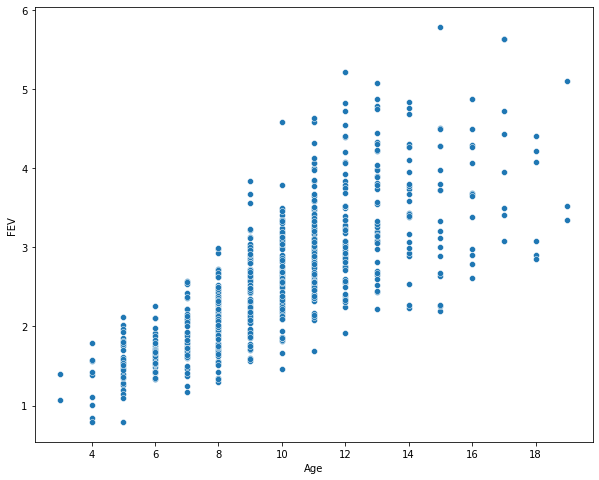

In [5]:
sns.scatterplot(data=fev, x="Age", y="FEV")
plt.show()

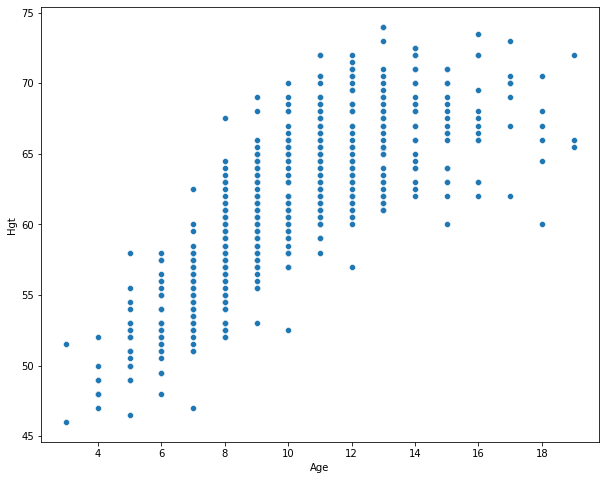

In [6]:
sns.scatterplot(data=fev, x="Age", y="Hgt")
plt.show()

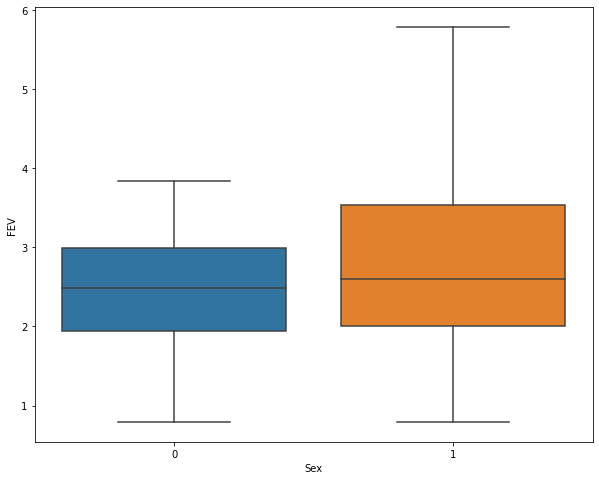

In [7]:
sns.boxplot(x="Sex", y="FEV", data=fev)
plt.show()

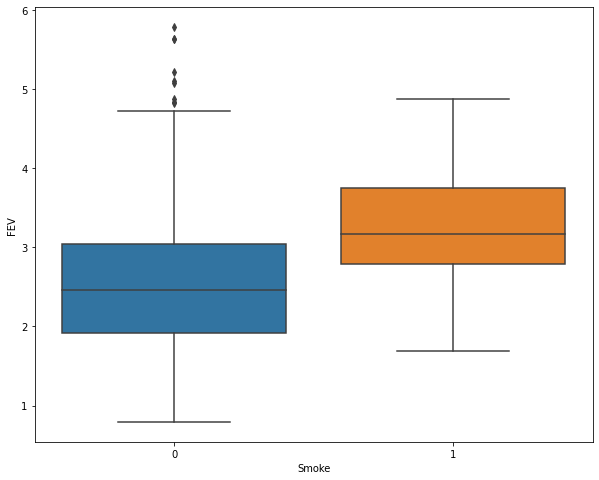

In [8]:
sns.boxplot(x="Smoke", y="FEV", data=fev)
plt.show()

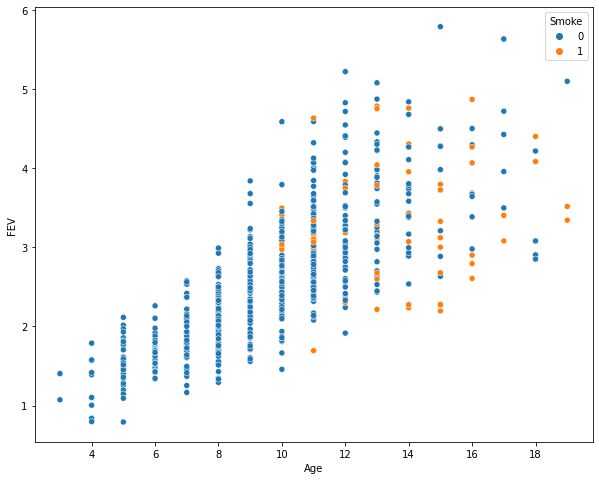

In [9]:
sns.scatterplot(data=fev, x="Age", y="FEV", hue="Smoke")
plt.show()

In [10]:
# MODELO DE REGRESSÃO LINEAR SIMPLES

import statsmodels.api as sm
import statsmodels.formula.api as smf

mod1 = smf.ols(formula = 'FEV ~ Smoke', data = fev)
res = mod1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FEV   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     41.79
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           1.99e-10
Time:                        18:27:44   Log-Likelihood:                -813.88
No. Observations:                 654   AIC:                             1632.
Df Residuals:                     652   BIC:                             1641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5661      0.035     74.037      0.0

In [11]:
# MODELO DE REGRESSÃO LINEAR MULTIPLA
mod2 = smf.ols(formula = 'FEV ~ Age + Smoke', data = fev)
res = mod2.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FEV   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     443.3
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          3.25e-122
Time:                        18:27:44   Log-Likelihood:                -553.17
No. Observations:                 654   AIC:                             1112.
Df Residuals:                     651   BIC:                             1126.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3674      0.081      4.511      0.0

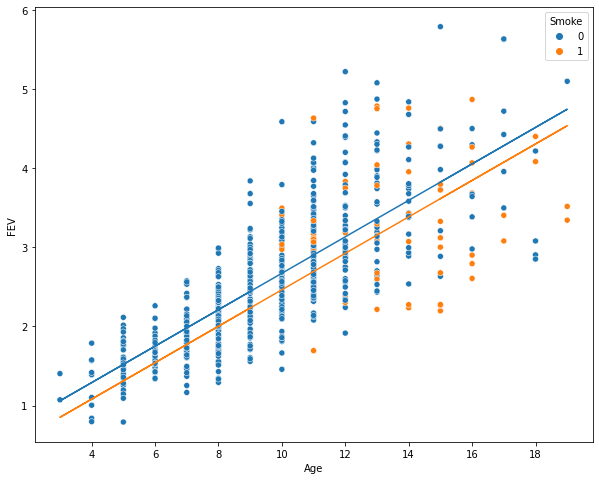

In [12]:
p = res.params

sns.scatterplot(data=fev, x="Age", y="FEV", hue = "Smoke")
plt.plot(fev.Age, p.Intercept + p.Age*fev.Age)
plt.plot(fev.Age, p.Intercept + p.Age*fev.Age + p.Smoke)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    FEV   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     317.1
Date:                Tue, 14 Dec 2021   Prob (F-statistic):          8.66e-127
Time:                        18:27:45   Log-Likelihood:                -539.37
No. Observations:                 654   AIC:                             1087.
Df Residuals:                     650   BIC:                             1105.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2534      0.083      3.066      0.0

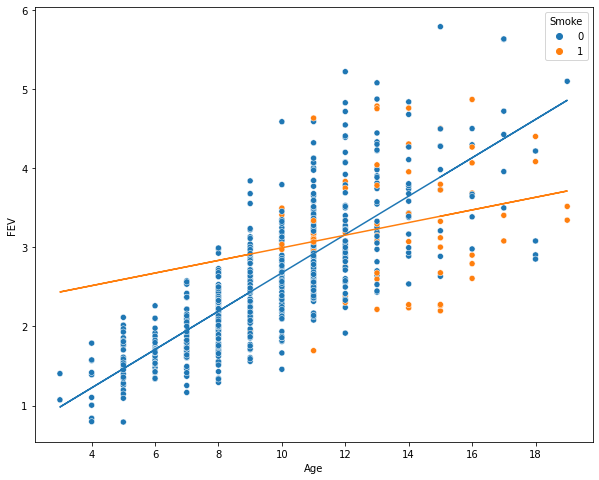

In [13]:
# MODELO DE REGRESSÃO LINEAR MULTIPLA - EFEITO DE INTERAÇÃO
model2 = smf.ols(formula = 'FEV ~ Age + Smoke + Age:Smoke', data = fev)
model_fit2 = model2.fit()
print(model_fit2.summary())

# PLOTANDO MODELO COM INTERAÇÃO #

p = model_fit2.params

sns.scatterplot(data=fev, x="Age", y="FEV", hue = "Smoke")
plt.plot(fev.Age, p.Intercept + p.Age*fev.Age)
plt.plot(fev.Age, p.Intercept + p.Age*fev.Age + p.Smoke -0.1627*fev.Age )
plt.show()

In [14]:
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

white_test = het_white(model_fit2.resid,  model_fit2.model.exog)

In [15]:
white_test

(88.14035285628,
 1.651364117920689e-17,
 20.186966481588705,
 9.601179773110242e-19)

In [16]:
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
dict(zip(labels, white_test))

{'LM Statistic': 88.14035285628,
 'LM-Test p-value': 1.651364117920689e-17,
 'F-Statistic': 20.186966481588705,
 'F-Test p-value': 9.601179773110242e-19}

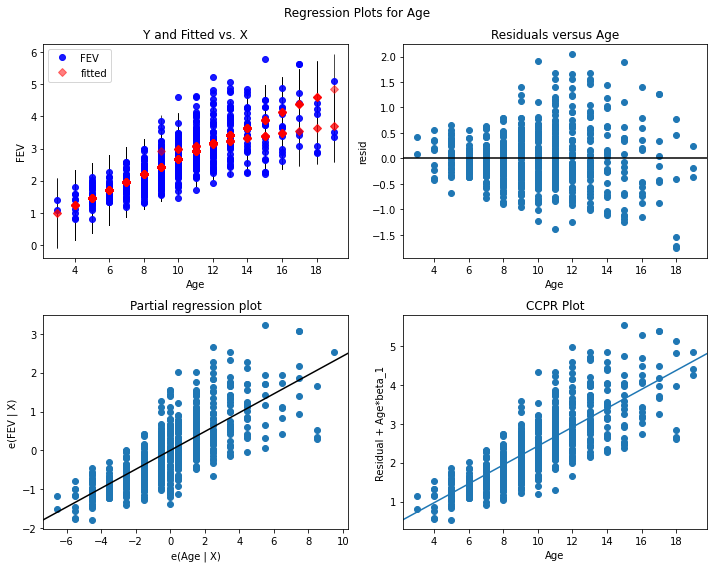

In [23]:
import statsmodels.api as sm
fig = sm.graphics.plot_regress_exog(model_fit2, 'Age')
fig.tight_layout(pad=1.0)